In [3]:
!pip3 install torch torchvision

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 69.6MB/s]


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def image_loader(image_path, max_size=500, shape=None):
    image = Image.open(image_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])
 
    image = in_transform(image).unsqueeze(0)
    
    return image




In [0]:
style_img = image_loader('./data/StarryNight.jpg').to(device)
content_img = image_loader('./data/City.jpg').to(device)

In [0]:
style_img = image_loader('./data/style3.jpg').to(device)
content_img = image_loader('./data/pikachu.jpg').to(device)

width:  833
height:  1000
width:  892
height:  780


In [0]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
 
    return image

(-0.5, 770.5, 499.5, -0.5)

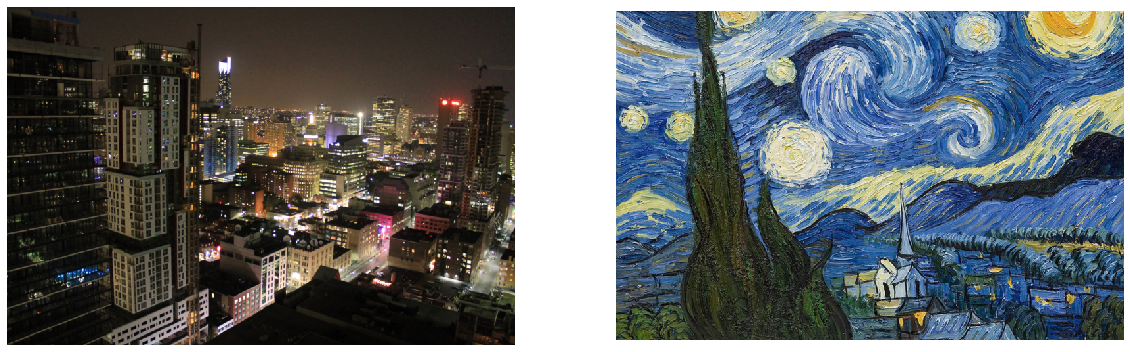

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_img))
ax1.axis("off")
ax2.imshow(im_convert(style_img))
ax2.axis("off")

(-0.5, 799.5, 959.5, -0.5)

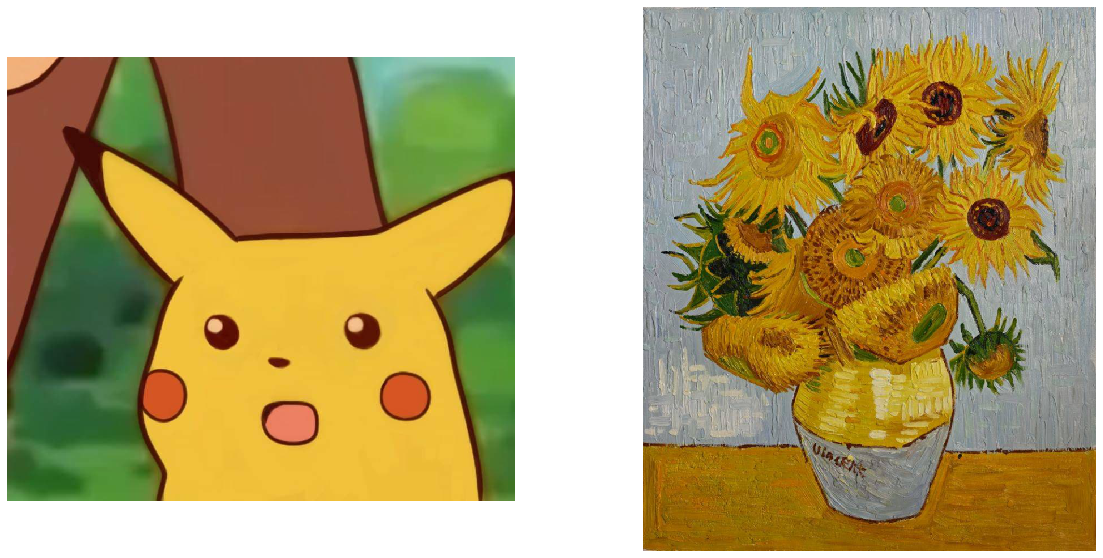

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_img))
ax1.axis("off")
ax2.imshow(im_convert(style_img))
ax2.axis("off")

In [0]:
def get_features(image, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '7': 'conv2_2',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '28': 'conv5_1'
  }
  features = {}
  for name, layer in model._modules.items():
    plt.imshow(im_convert(image))
    plt.axis("off")
    plt.show()
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
     
  return features

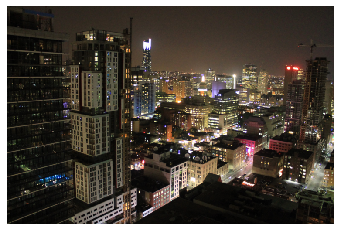

ValueError: ignored

In [22]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

In [0]:
def gram_matrix(input_tensor):
  _,d,h,w = input_tensor.size() #batch_size, depth, height, width
  features = input_tensor.view(d, h*w) #2D tensor
  # features = input_tensor.view(a*b, c*d)
  G = torch.mm(features, features.t())
  return G

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
style_weights = {
    'conv1_1': 1., 
    'conv2_1': 0.75, 
    'conv3_1': 0.2, 
    'conv4_1': 0.2, 
    'conv5_1': 0.2
}

content_weight = 0.7
style_weight = 1e2

In [0]:
target_img = content_img.clone().requires_grad_(True)

In [0]:
show_every = 300
optimizer = optim.Adam([target_img], lr=0.006)
steps = 2100
height, width, channels = im_convert(target_img).shape

img_array = np.empty(shape = (300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  1036.486083984375
Iteration:  600


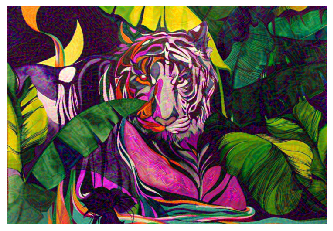

Total loss:  227.86790466308594
Iteration:  1200


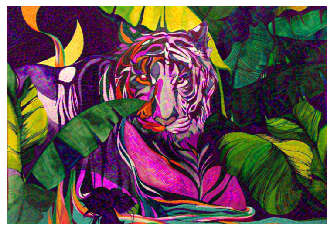

Total loss:  90.46875762939453
Iteration:  1800


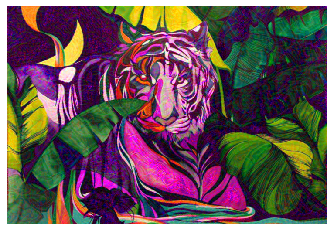

Total loss:  51.8989143371582
Iteration:  2400


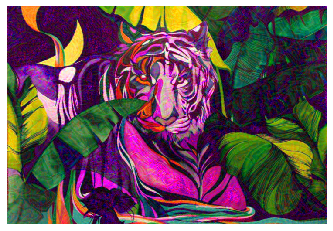

Total loss:  36.19228744506836
Iteration:  3000


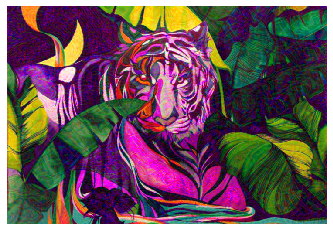

In [0]:
for ii in range(1, steps+1):
  target_features = get_features(target_img, vgg)
  content_loss = torch.mean((target_features['conv2_2'] - content_features['conv2_2'])**2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_loss * content_weight + style_loss * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target_img))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    img_array[counter] = im_convert(target_img)
    counter += 1
  
  
  
  
  
    

Total loss:  57.963539123535156
Iteration:  300


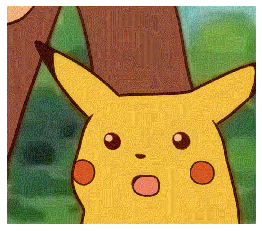

Total loss:  25.501081466674805
Iteration:  600


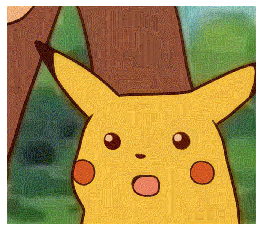

Total loss:  15.498400688171387
Iteration:  900


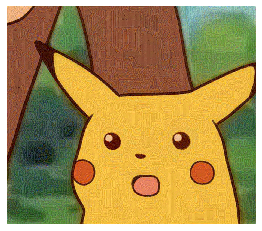

Total loss:  10.953136444091797
Iteration:  1200


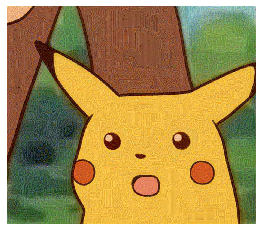

Total loss:  8.432555198669434
Iteration:  1500


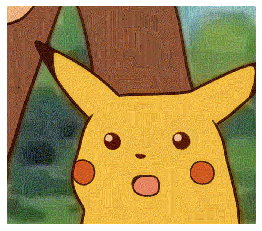

Total loss:  6.851640701293945
Iteration:  1800


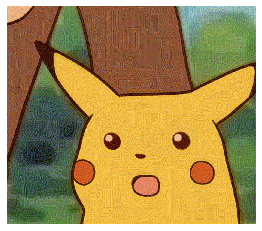

Total loss:  5.776524543762207
Iteration:  2100


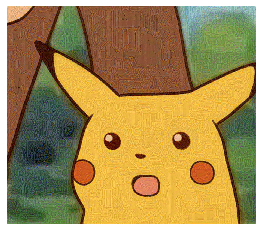

In [0]:
for ii in range(1, steps+1):
  target_features = get_features(target_img, vgg)
  content_loss = torch.mean((target_features['conv2_2'] - content_features['conv2_2'])**2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_loss * content_weight + style_loss * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target_img))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    img_array[counter] = im_convert(target_img)
    counter += 1
  